# The Sleep-Deprived Internet  
## Posting Time, Sentiment, and Quality of Life (DSA210 Term Project)

**Course:** DSA210 – Introduction to Data Science (Fall 2025–2026)

In this project, I look at whether people write differently late at night on the internet.

To satisfy the “use a second dataset to enrich your project” requirement, I combine:
- **Dataset 1:** [Tweets (text + timestamp + sentiment labels/scores)](https://www.kaggle.com/datasets/tango911/airline-sentiment-tweets)
- **Dataset 2:** [Quality of Life Index by Country](https://www.kaggle.com/datasets/marcelobatalhah/quality-of-life-index-by-country)

Main idea:  
1) Compare **night vs day** tweets (sentiment + language).  
2) Test if **posting time** can be predicted from text (ML).  
3) Enrich the analysis by connecting country-level behavior with quality-of-life indices.


In [67]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.style.use("seaborn-v0_8")


## Loading the Data

I load two datasets:

1) Tweets dataset (`Tweets[1].csv`)  
2) Quality of Life dataset (`quality_of_life_indices_by_country.csv`)


In [68]:
tweets_df = pd.read_csv("Tweets[1].csv")
qol_df = pd.read_csv("quality_of_life_indices_by_country.csv")

tweets_df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [69]:
qol_df.head()


,Rank,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index,Year
0,1,Switzerland,222.9,146.5,73.2,66.3,126.0,7.3,25.6,24.1,-,2015
1,2,Germany,195.9,111.8,71.5,75.6,76.3,6.6,31.1,28.3,-,2015
2,3,Sweden,193.9,110.9,57.9,76.3,82.9,9.2,26.9,15.1,-,2015
3,4,United States,192.5,126.1,50.0,67.8,76.5,2.6,36.0,31.4,-,2015
4,5,Finland,190.2,101.2,70.5,69.4,89.7,7.0,33.2,14.9,-,2015


## Quick sanity check (shapes + columns)


In [70]:
print("Tweets shape:", tweets_df.shape)
print("QoL shape:", qol_df.shape)

print("\nTweets columns:")
print(list(tweets_df.columns))

print("\nQoL columns:")
print(list(qol_df.columns))


Tweets shape: (14640, 15)
QoL shape: (1495, 12)

Tweets columns:
['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

QoL columns:
['Rank', 'Country', 'Quality of Life Index', 'Purchasing Power Index', 'Safety Index', 'Health Care Index', 'Cost of Living Index', 'Property Price to Income Ratio', 'Traffic Commute Time Index', 'Pollution Index', 'Climate Index', 'Year']


## Creating Night vs Day Labels

The tweets dataset includes a `tweet_created` column (string).  
I convert it to datetime, extract the hour, and then define:

- **Night:** 00:00–06:00  
- **Day:** 08:00–22:00  
- Hours outside these ranges are labeled **other** and removed for clean comparison.


In [71]:
tweets_df["tweet_created_dt"] = pd.to_datetime(tweets_df["tweet_created"], errors="coerce")

# How many failed parses?
tweets_df["tweet_created_dt"].isna().mean()


0.0

In [72]:
tweets_df["hour"] = tweets_df["tweet_created_dt"].dt.hour

def time_bucket(hour):
    if pd.isna(hour):
        return np.nan
    if 0 <= hour <= 6:
        return "night"
    elif 8 <= hour <= 22:
        return "day"
    else:
        return "other"

tweets_df["time_bucket"] = tweets_df["hour"].apply(time_bucket)

tweets_df["time_bucket"].value_counts(dropna=False)


time_bucket
day      11564
night     2107
other      969
Name: count, dtype: int64

In [73]:
# Keep only clean night/day for analysis
tweets_df = tweets_df[tweets_df["time_bucket"].isin(["night", "day"])].copy()
tweets_df["is_night"] = (tweets_df["time_bucket"] == "night").astype(int)

tweets_df[["tweet_created", "tweet_created_dt", "hour", "time_bucket", "is_night"]].head()


,tweet_created,tweet_created_dt,hour,time_bucket,is_night
0,2015-02-24 11:35:52 -0800,2015-02-24 11:35:52-08:00,11,day,0
1,2015-02-24 11:15:59 -0800,2015-02-24 11:15:59-08:00,11,day,0
2,2015-02-24 11:15:48 -0800,2015-02-24 11:15:48-08:00,11,day,0
3,2015-02-24 11:15:36 -0800,2015-02-24 11:15:36-08:00,11,day,0
4,2015-02-24 11:14:45 -0800,2015-02-24 11:14:45-08:00,11,day,0


## Exploratory Data Analysis (Tweets)

First, I do quick EDA:
- Night vs day counts
- Sentiment label distribution
- Average sentiment confidence by time_bucket


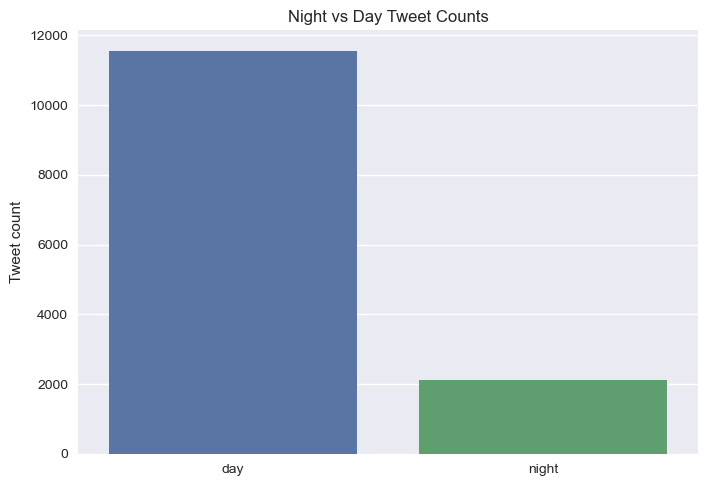

In [74]:
sns.countplot(data=tweets_df, x="time_bucket")
plt.title("Night vs Day Tweet Counts")
plt.xlabel("")
plt.ylabel("Tweet count")
plt.show()


In [75]:
# Sentiment label distribution overall
tweets_df["airline_sentiment"].value_counts(normalize=True)


airline_sentiment
negative    0.626216
neutral     0.211982
positive    0.161802
Name: proportion, dtype: float64

In [76]:
# Sentiment distribution by time_bucket
pd.crosstab(tweets_df["time_bucket"], tweets_df["airline_sentiment"], normalize="index")


airline_sentiment,negative,neutral,positive
time_bucket,,,
day,0.621325,0.213421,0.165254
night,0.653061,0.204082,0.142857


In [77]:
# Confidence summary by time_bucket
tweets_df.groupby("time_bucket")["airline_sentiment_confidence"].agg(["count","mean","std"])


,count,mean,std
time_bucket,,,
day,11564,0.898974,0.163908
night,2107,0.906308,0.157864


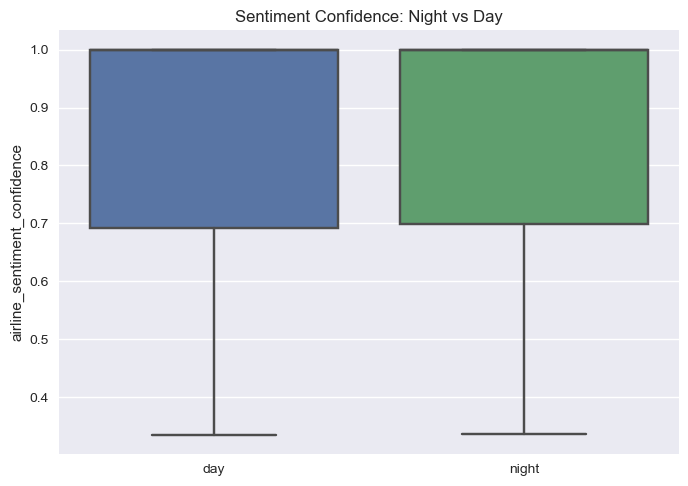

In [78]:
sns.boxplot(data=tweets_df, x="time_bucket", y="airline_sentiment_confidence")
plt.title("Sentiment Confidence: Night vs Day")
plt.xlabel("")
plt.ylabel("airline_sentiment_confidence")
plt.show()


### Text length check (simple)


In [79]:
tweets_df["text_len"] = tweets_df["text"].astype(str).str.len()

tweets_df.groupby("time_bucket")["text_len"].agg(["count","mean","std"])


,count,mean,std
time_bucket,,,
day,11564,103.380405,36.430505
night,2107,105.532036,35.355101


c:\Users\osman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\osman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\osman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\osman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

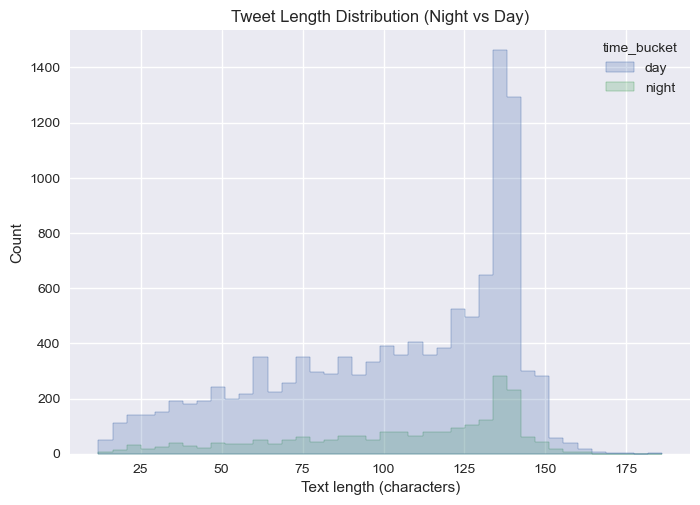

In [80]:
sns.histplot(data=tweets_df, x="text_len", hue="time_bucket", bins=40, element="step")
plt.title("Tweet Length Distribution (Night vs Day)")
plt.xlabel("Text length (characters)")
plt.show()


# Statistical Hypothesis Testing (Simple)

I use the sentiment information that already exists in the dataset.

**H₀:** Mean `airline_sentiment_confidence` is the same for night and day tweets.  
**H₁:** The mean confidence differs between night and day tweets.


In [81]:
night_conf = tweets_df[tweets_df["is_night"] == 1]["airline_sentiment_confidence"]
day_conf = tweets_df[tweets_df["is_night"] == 0]["airline_sentiment_confidence"]

night_conf.mean(), day_conf.mean()


(0.9063075937351684, 0.8989744811483916)

In [82]:
t_stat, p_val = stats.ttest_ind(night_conf, day_conf, equal_var=False)
t_stat, p_val


(1.9493750875106821, 0.051343911772038564)

In [83]:
if p_val < 0.05:
    print("Result: Reject H0 (night vs day confidence means are statistically different).")
else:
    print("Result: Fail to reject H0 (no statistically significant difference).")


Result: Fail to reject H0 (no statistically significant difference).


## Test 2 (Chi-square): sentiment label distribution
This one checks if sentiment **categories** (negative / neutral / positive) depend on time_bucket.

**H₀:** Sentiment label distribution is independent of posting time (night/day).  
**H₁:** Sentiment label distribution depends on posting time.


In [84]:
contingency = pd.crosstab(tweets_df["time_bucket"], tweets_df["airline_sentiment"])
contingency


airline_sentiment,negative,neutral,positive
time_bucket,,,
day,7185,2468,1911
night,1376,430,301


In [85]:
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)
chi2, p_chi


(9.12541124210512, 0.010433790835135247)

In [86]:
if p_chi < 0.05:
    print("Result: Reject H0 (sentiment category distribution differs for night vs day).")
else:
    print("Result: Fail to reject H0 (no significant association detected).")


Result: Reject H0 (sentiment category distribution differs for night vs day).


# Enrichment with a 2nd Dataset (Quality of Life)

Project requirement: if I use a public dataset, I should enrich it with another dataset.

Here I connect tweeting behavior to country-level quality of life indicators.

**How I assign country (approximate):**  
The tweets dataset has a `user_timezone` column. I map common timezones to a country label.  
This is not perfect location data, so I treat this as **exploratory** and aggregate at country level.


In [87]:
# Show the most common timezones
tweets_df["user_timezone"].value_counts().head(15)


user_timezone
Eastern Time (US & Canada)     3477
Central Time (US & Canada)     1796
Pacific Time (US & Canada)     1153
Quito                           679
Atlantic Time (Canada)          467
Mountain Time (US & Canada)     355
Arizona                         218
London                          184
Alaska                          103
Sydney                          101
Hawaii                           92
Amsterdam                        72
America/Chicago                  37
America/New_York                 26
Indiana (East)                   25
Name: count, dtype: int64

In [88]:
def timezone_to_country(tz):
    if pd.isna(tz):
        return np.nan

    tz = tz.lower()

    # United States
    if any(k in tz for k in [
        "eastern time", "central time", "pacific time",
        "mountain time", "alaska", "hawaii", "arizona",
        "america/new_york", "america/chicago", "indiana"
    ]):
        return "United States"

    # Canada
    elif "canada" in tz or "atlantic time" in tz:
        return "Canada"

    # United Kingdom
    elif "london" in tz or "uk" in tz:
        return "United Kingdom"

    # Ecuador
    elif "quito" in tz:
        return "Ecuador"

    # Australia
    elif "sydney" in tz:
        return "Australia"

    # Netherlands
    elif "amsterdam" in tz:
        return "Netherlands"

    else:
        return np.nan

tweets_df["country"] = tweets_df["user_timezone"].apply(timezone_to_country)
tweets_df["country"].value_counts(dropna=False).head(20)


country
United States     7282
NaN               4886
Ecuador            679
Canada             467
United Kingdom     184
Australia          101
Netherlands         72
Name: count, dtype: int64

In [89]:
# Keep only tweets with a mapped country
tweets_country_df = tweets_df.dropna(subset=["country"]).copy()
tweets_country_df["country"].value_counts()


country
United States     7282
Ecuador            679
Canada             467
United Kingdom     184
Australia          101
Netherlands         72
Name: count, dtype: int64

## Aggregate night-posting behavior by country


In [90]:
country_night_stats = (
    tweets_country_df
    .groupby("country")
    .agg(
        total_posts=("is_night", "count"),
        night_posts=("is_night", "sum"),
        night_ratio=("is_night", "mean"),
        avg_confidence=("airline_sentiment_confidence", "mean")
    )
    .reset_index()
)

country_night_stats


,country,total_posts,night_posts,night_ratio,avg_confidence
0,Australia,101,29,0.287129,0.882642
1,Canada,467,76,0.162741,0.913382
2,Ecuador,679,94,0.138439,0.913482
3,Netherlands,72,21,0.291667,0.881771
4,United Kingdom,184,66,0.358696,0.903099
5,United States,7282,1059,0.145427,0.895111


## Prepare Quality of Life dataset (keep key columns)


In [91]:
qol_clean = qol_df[[
    "Country",
    "Quality of Life Index",
    "Purchasing Power Index",
    "Safety Index",
    "Health Care Index",
    "Cost of Living Index",
    "Pollution Index"
]].copy()

qol_clean.head()


,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Pollution Index
0,Switzerland,222.9,146.5,73.2,66.3,126.0,24.1
1,Germany,195.9,111.8,71.5,75.6,76.3,28.3
2,Sweden,193.9,110.9,57.9,76.3,82.9,15.1
3,United States,192.5,126.1,50.0,67.8,76.5,31.4
4,Finland,190.2,101.2,70.5,69.4,89.7,14.9


## Merge country-level tweet stats with Quality of Life indices


In [92]:
merged_df = pd.merge(
    country_night_stats,
    qol_clean,
    left_on="country",
    right_on="Country",
    how="inner"
)

merged_df


,country,total_posts,night_posts,night_ratio,avg_confidence,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Pollution Index
0,Australia,101,29,0.287129,0.882642,Australia,180.8,110.4,57.8,71.9,99.3,21.6
1,Australia,101,29,0.287129,0.882642,Australia,227.2,158.0,56.6,72.7,89.5,23.1
2,Australia,101,29,0.287129,0.882642,Australia,198.8,147.3,56.9,73.7,78.5,22.9
3,Australia,101,29,0.287129,0.882642,Australia,196.4,137.3,58.0,74.1,79.7,24.1
4,Australia,101,29,0.287129,0.882642,Australia,176.5,101.9,57.6,74.2,80.7,24.6
...,...,...,...,...,...,...,...,...,...,...,...,...
107,United States,7282,1059,0.145427,0.895111,United States,167.2,99.9,51.6,68.9,69.9,35.7
108,United States,7282,1059,0.145427,0.895111,United States,172.7,115.7,51.0,68.6,72.4,36.1
109,United States,7282,1059,0.145427,0.895111,United States,173.0,117.7,50.8,68.2,74.2,36.5
110,United States,7282,1059,0.145427,0.895111,United States,174.0,120.9,50.7,67.6,72.9,37.1


## Simple enrichment visuals + correlation


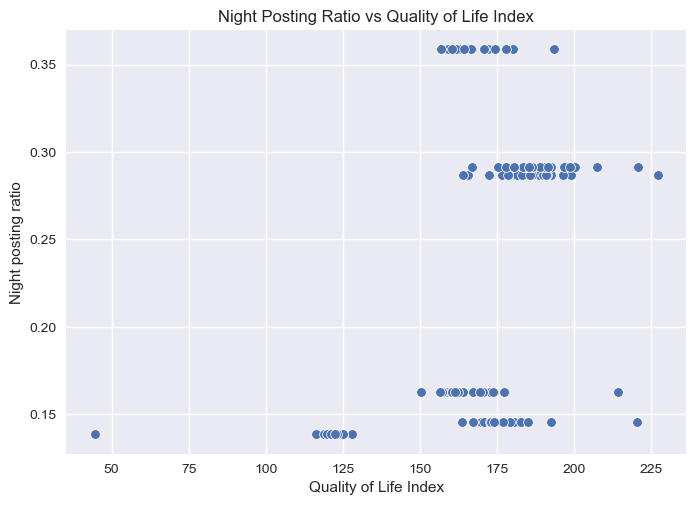

In [93]:
sns.scatterplot(data=merged_df, x="Quality of Life Index", y="night_ratio")
plt.title("Night Posting Ratio vs Quality of Life Index")
plt.xlabel("Quality of Life Index")
plt.ylabel("Night posting ratio")
plt.show()


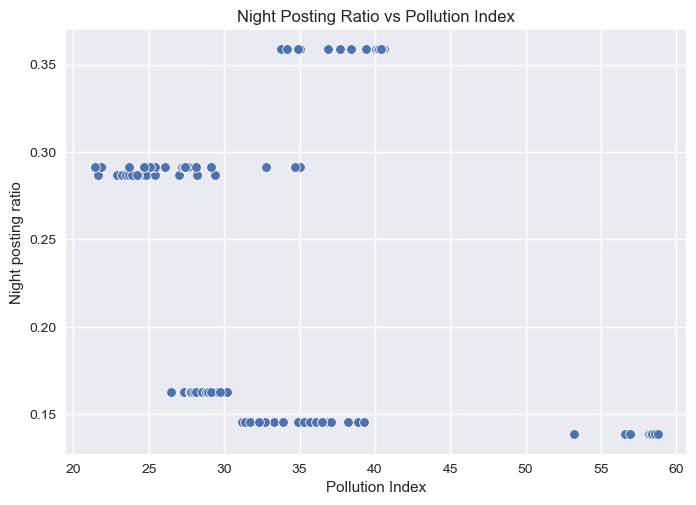

In [94]:
sns.scatterplot(data=merged_df, x="Pollution Index", y="night_ratio")
plt.title("Night Posting Ratio vs Pollution Index")
plt.xlabel("Pollution Index")
plt.ylabel("Night posting ratio")
plt.show()


In [95]:
corr_qol = merged_df["night_ratio"].corr(merged_df["Quality of Life Index"])
corr_pollution = merged_df["night_ratio"].corr(merged_df["Pollution Index"])
corr_qol, corr_pollution


(0.3598118100074597, -0.2944689195356561)

*(Keeping it simple)* I treat these correlations as descriptive signals, not causal claims.


# Machine Learning: Predict Night vs Day from Text

Goal: can we predict `is_night` using only tweet text?

I start with a simple baseline:
- TF-IDF vectorization of `text` (gpt proposed.)
- Several classic classifiers
- Evaluate with Accuracy / F1 / Precision / Recall


In [96]:
# Features and target
X = tweets_df["text"].astype(str)
y = tweets_df["is_night"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_test.value_counts(normalize=True)


is_night
0    0.845704
1    0.154296
Name: proportion, dtype: float64

In [97]:
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [98]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": LinearSVC(),
    "Multinomial Naive Bayes": MultinomialNB()
}

results = []

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall": recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,F1-Score,Precision,Recall
0,Logistic Regression,0.845704,0.000000,0.000000,0.000000
1,Random Forest,0.832907,0.053830,0.213115,0.030806
2,Linear SVM,0.828519,0.113422,0.280374,0.071090
3,Multinomial Naive Bayes,0.845338,0.000000,0.000000,0.000000


## Class Imbalance Debugging (what happened and how I fixed it) [AI disclosure]

At first, my results looked weird: **accuracy was high** but **F1 / precision / recall were very low (sometimes 0)**.

I asked for help (as if talking to a senior data scientist), and the key idea was:

- If a dataset is imbalanced, a model can get high accuracy by always predicting the majority class.
- That produces terrible minority-class metrics (precision/recall/F1) and can even lead to **F1 = 0**.

To confirm, I checked the class distribution:

```python
y_test.value_counts(normalize=True)
```

It showed a strong imbalance (about **85% day** vs **15% night**), so the fix was to balance classes.

### The simplest and effective fix: oversampling with `resample`

Below is the exact code that was suggested and used:


In [99]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = tweets_df[tweets_df["is_night"] == 0]
df_minority = tweets_df[tweets_df["is_night"] == 1]

# Oversample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,                 # sample with replacement
    n_samples=len(df_majority),   # match majority class
    random_state=42
)

# Combine back
tweets_df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle dataset
tweets_df_balanced = tweets_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
tweets_df_balanced["is_night"].value_counts(normalize=True)


is_night
0    0.5
1    0.5
Name: proportion, dtype: float64

## ML After Resampling (same pipeline, balanced data)

Now I re-run the exact same ML pipeline, but using `tweets_df_balanced`.


In [100]:
Xb = tweets_df_balanced["text"].astype(str)
yb = tweets_df_balanced["is_night"]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.2, random_state=42, stratify=yb
)

tfidf_b = TfidfVectorizer(max_features=5000, stop_words="english")
Xb_train_tfidf = tfidf_b.fit_transform(Xb_train)
Xb_test_tfidf = tfidf_b.transform(Xb_test)

results_balanced = []

for name, model in models.items():
    model.fit(Xb_train_tfidf, yb_train)
    yb_pred = model.predict(Xb_test_tfidf)

    results_balanced.append({
        "Model": name,
        "Accuracy": accuracy_score(yb_test, yb_pred),
        "F1-Score": f1_score(yb_test, yb_pred, pos_label=1, zero_division=0),
        "Precision": precision_score(yb_test, yb_pred, pos_label=1, zero_division=0),
        "Recall": recall_score(yb_test, yb_pred, pos_label=1, zero_division=0)
    })

results_balanced_df = pd.DataFrame(results_balanced)
results_balanced_df


,Model,Accuracy,F1-Score,Precision,Recall
0,Logistic Regression,0.765456,0.770078,0.755195,0.785560
1,Random Forest,0.962603,0.963464,0.941784,0.986165
2,Linear SVM,0.820147,0.826377,0.798709,0.856031
3,Multinomial Naive Bayes,0.757890,0.740621,0.797506,0.691310


After resampling, the models perform much better on the minority class (night tweets).  
This shows the earlier near-zero scores were driven by imbalance rather than “no signal”.


# Conclusion

In this project, I compared **night (00:00–06:00)** vs **day (08:00–22:00)** tweets using the sentiment fields that already exist in the dataset, and then enriched the analysis with a second dataset (**Quality of Life Index by Country**).

## What I found (in plain terms)

### 1) Sentiment confidence (Welch t-test)
- Night mean confidence ≈ **0.9063**, Day mean confidence ≈ **0.8990**, p-value ≈ **0.0513**

So, the confidence difference is **very small**, and statistically it is **right on the edge** of significance.
With a 0.05 threshold, this means I **fail to reject H₀** (no strong evidence of a mean difference).

### 2) Sentiment category distribution (Chi-square test)
- Chi-square p-value ≈ **0.0104**. I **reject H₀** here.

This means that even if the *average confidence* is similar, the **distribution of sentiment labels**
(negative/neutral/positive) **does differ** between night and day.

### 3) Machine Learning (predict night vs day from text)
At first, ML metrics were misleading: accuracy looked high but F1/recall could be near zero.
This happened because the data was imbalanced:

- Day ≈ **84.6%**, Night ≈ **15.4%**

After fixing this with a simple oversampling resampling approach, model performance became meaningful.
Random Forest performed best after resampling (very high F1/recall), showing that there **is signal in the text**
related to posting time, but imbalance can hide it.

### 4) Enrichment with Quality of Life (2nd dataset)
By aggregating tweets at country level (using timezone → country mapping), I merged tweet behavior with
quality-of-life indicators. The resulting relationships are **exploratory**, but they suggest that late-night posting
patterns may connect to broader living conditions.

## Final takeaway
Overall, the “sleep-deprived internet” effect seems **real but nuanced**:
- Not everything changes (average confidence is very similar),
- but the **mix of sentiment categories** and **language patterns** differs enough that ML can detect it,
especially when class imbalance is handled correctly.